<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/NLP/Text_classification/news_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification

In [ ]:
%%capture
!pip install datasets

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data preparation

In [ ]:
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
words = Counter()
for example in tqdm(dataset['train']['text']):
  processed_text = example.lower().translate(str.maketrans('', '', string.punctuation))
  for word in word_tokenize(processed_text):
    words[word] += 1

  0%|          | 0/120000 [00:00<?, ?it/s]

In [ ]:
tags = ['<unk>', '<bos>',' <eos>', '<pad>']
vocab = set(tags)
counter_threshold = 25

In [ ]:
for char, count in words.items():
  if count > counter_threshold:
    vocab.add(char)

In [ ]:
word2idx = {char:i for i, char in enumerate(vocab)}
idx2word = {i:char for char, i in word2idx.items()}

### WordDataset class

In [ ]:
class WordDataset:
  def __init__(self, sent):
    self.data = sent
    self.unk_id, self.bos_id, self.eos_id, self.pad_id  = [word2idx[tag] for tag in tags]




  def ___getitem__(self, idx: int) -> list:
    processed_txt = self.data[idx]['text'].lower().translate(str.maketrans('', '', string.punctuation))
    tok_sent = [self.bos_id]
    tok_sent += [word2idx.get(word, self.unk_id) for word in word_tokenize(processed_txt)]
    tok_sent += [self.eos_id]

    train_sample = {
        'text': tok_sent,
        'label': self.data[idx]['label']
    }
    return train_sample
  def __getitem__(self, idx: int) -> dict:
    processed_txt = self.data[idx]['text'].lower().translate(str.maketrans('', '', string.punctuation))
    tok_sent = [self.bos_id]
    tok_sent += [word2idx.get(word, self.unk_id) for word in word_tokenize(processed_txt)]
    tok_sent += [self.eos_id]

    train_sample = {
        'text': tok_sent,
        'label': self.data[idx]['label']
    }
    return train_sample


  def __len__(self) -> int:
    return len(self.data)


def collate_fn_with_padding(input_batch: List[List[int]], pad_id=word2idx["<pad>"], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for seq in input_batch:
        seq['text'] = seq['text'][:max_seq_len]
        for _ in range(max_seq_len - len(seq['text'])):
            seq['text'].append(pad_id)

        new_batch.append(seq['text'])

    seqs = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)
    return {'input_idx': seqs, 'label': labels}



def collate_fn_with_padding_2(input_batch, pad_id, max_len):
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)
    new_batch = []
    labels = []
    for item in input_batch:
        p_seq = item['text'][:max_seq_len] + [pad_id] * (max_seq_len - len(item['text']))
        new_batch.append(p_seq)
        labels.append(item['label'])
    seqs = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor(labels).to(device)
    return {'input_idx': seqs, 'label': labels}


### Split and load data

In [ ]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Task

Get highest score with evaluate func

In [ ]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_idx'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Experiment

### Baseline

In [ ]:
class RNNModel(nn.Module):
  def __init__(self, vocab_size: int, hidden_dim: int = 512, num_classes: int = 4, bi = False, rnn_layers = 2):
    super(RNNModel, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_dim)
    self.drop = nn.Dropout(0.2)
    self.rnn = nn.RNN(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=rnn_layers, batch_first=True, bidirectional=bi)
    self.fc_1 = nn.Linear(in_features=hidden_dim*(bi+1), out_features=hidden_dim//2)
    self.fc_2 = nn.Linear(in_features=hidden_dim//2, out_features=num_classes)

  def forward(self, x):
    embeddings = self.embedding(x)
    x, last_cell = self.rnn(embeddings)
    x = F.tanh(x.max(dim=1)[0])
    x = self.fc_1(x)
    x = F.relu(x)
    x = self.drop(x)
    x = self.fc_2(x)
    return x

In [ ]:
class CFG:
  epochs=6

def get_score(value, loader):
  return value / len(loader)

def round_score(ilist, idx, n=3):
  return round(ilist[idx], n)

In [ ]:
def plot_loss_and_acc(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss', color='red')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='red')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Train baseline and calc score (1 point)

In [ ]:
class CharLM(nn.Module):  # Charlemagne?
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
def epoch_train(model, loader, optimizer, criterion, name, n):
  avg_loss = 0
  avg_acc = 0
  for batch in tqdm(loader, desc=f"Epoch {name}: {n}"):
      X, y = batch["input_idx"], batch["label"]
      y_hat = model(X)
      loss = criterion(y_hat, y)

      if name == 'Train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      avg_loss += loss.item()
      probs = torch.softmax(y_hat, dim=1)
      y_pred = torch.argmax(probs, dim=1)
      avg_acc += (y_pred == y).sum().item() / len(y)
  loss_score = get_score(avg_loss, loader)
  acc_score =  get_score(avg_acc, loader)
  print(f'loss: {round(loss_score, 4)}\nacc: {round(acc_score*100, 2)}')
  return loss_score, acc_score

In [ ]:
def fit(model, optimizer, criterion, scheduler, trainloader, valloader):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    best_model = None
    best_val_acc = 0.0

    for epoch in tqdm(range(CFG.epochs)):

        model.train()
        train_avg_loss, train_avg_acc = epoch_train(model, trainloader, optimizer, criterion, 'Train', epoch+1)
        scheduler.step()

        train_loss.append(train_avg_loss)
        train_acc.append(train_avg_acc)

        model.eval()
        with torch.no_grad():
          val_avg_loss, val_avg_acc = epoch_train(model, valloader, optimizer, criterion, 'Val', epoch+1)

        val_loss.append(val_avg_loss)
        val_acc.append(val_avg_acc)

        if val_avg_acc > best_val_acc:  # Check if current validation accuracy is better than the best so far
            best_val_acc = val_avg_acc
            best_model = model.state_dict()


        best_idx = val_acc.index(max(val_acc))
        print(f"Epoch: {epoch+1}/{CFG.epochs}:\n\tTrain: \
                                 \n\t\ttrain_loss = {round_score(train_loss, best_idx, 5)} \
                                 \n\t\ttrain acc = {round_score(train_acc, best_idx)}% \
                                 \n\tVal: \
                                 \n\t\tval loss = {round_score(val_loss, best_idx, 5)} \
                                  \n\t\tval acc = {round_score(val_acc, best_idx)}%")
    model.load_state_dict(best_model)
    model.eval()
    return  model, (train_loss, val_loss, train_acc, val_acc)

In [ ]:
OUTPUT_DIM = len(set(dataset['train']['label'])) # Number of classes
PAD_IDX = word2idx['<pad>']

In [ ]:
def test_model(model_class, train_dataloder=train_dataloader, eval_dataloader=eval_dataloader, hd=512, lr=4e-4):

  model = model_class(vocab_size=len(vocab), hidden_dim=hd, num_classes=4).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX).to(device)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.5)
  best_model, history = fit(model, optimizer, criterion, scheduler, train_dataloader, eval_dataloader)
  plot_loss_and_acc(*history)
  return best_model


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.3873
acc: 86.04


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.333
acc: 88.08
Epoch: 1/5:
	Train:                                  
		train_loss = 0.38733                                  
		train acc = 0.86%                                  
	Val:                                  
		val loss = 0.33298                                   
		val acc = 0.881%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2552
acc: 91.17


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2858
acc: 90.19
Epoch: 2/5:
	Train:                                  
		train_loss = 0.25523                                  
		train acc = 0.912%                                  
	Val:                                  
		val loss = 0.28579                                   
		val acc = 0.902%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2149
acc: 92.49


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.283
acc: 90.82
Epoch: 3/5:
	Train:                                  
		train_loss = 0.21485                                  
		train acc = 0.925%                                  
	Val:                                  
		val loss = 0.28296                                   
		val acc = 0.908%


Epoch Train: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.182
acc: 93.58


Epoch Val: 4:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2894
acc: 90.68
Epoch: 4/5:
	Train:                                  
		train_loss = 0.21485                                  
		train acc = 0.925%                                  
	Val:                                  
		val loss = 0.28296                                   
		val acc = 0.908%


Epoch Train: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1574
acc: 94.44


Epoch Val: 5:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3164
acc: 90.64
Epoch: 5/5:
	Train:                                  
		train_loss = 0.21485                                  
		train acc = 0.925%                                  
	Val:                                  
		val loss = 0.28296                                   
		val acc = 0.908%


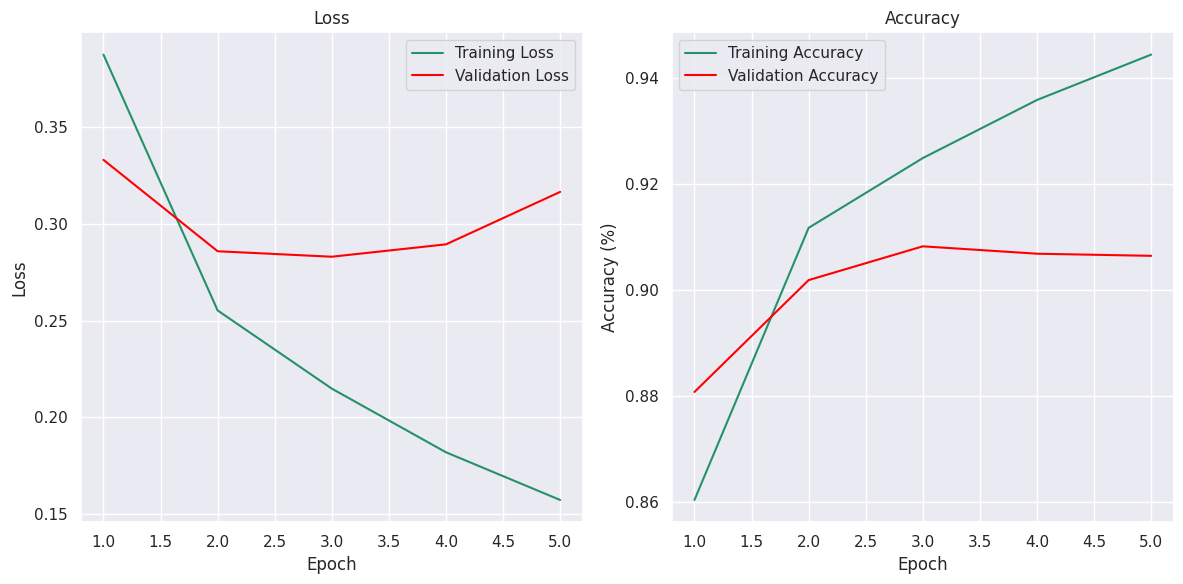

0.9059999585151672

In [ ]:
CFG.epochs=5
baseline = test_model(CharLM)
evaluate(baseline, eval_dataloader)

As expected. Meh. And overfits

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.4315
acc: 84.19


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3604
acc: 87.76
Epoch: 1/6:
	Train:                                  
		train_loss = 0.43145                                  
		train acc = 0.842%                                  
	Val:                                  
		val loss = 0.36039                                   
		val acc = 0.878%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2669
acc: 90.88


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3248
acc: 88.81
Epoch: 2/6:
	Train:                                  
		train_loss = 0.26689                                  
		train acc = 0.909%                                  
	Val:                                  
		val loss = 0.32475                                   
		val acc = 0.888%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2207
acc: 92.43


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2761
acc: 90.43
Epoch: 3/6:
	Train:                                  
		train_loss = 0.22074                                  
		train acc = 0.924%                                  
	Val:                                  
		val loss = 0.27614                                   
		val acc = 0.904%


Epoch Train: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1871
acc: 93.5


Epoch Val: 4:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2845
acc: 90.9
Epoch: 4/6:
	Train:                                  
		train_loss = 0.18713                                  
		train acc = 0.935%                                  
	Val:                                  
		val loss = 0.28451                                   
		val acc = 0.909%


Epoch Train: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1601
acc: 94.38


Epoch Val: 5:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2879
acc: 91.18
Epoch: 5/6:
	Train:                                  
		train_loss = 0.16012                                  
		train acc = 0.944%                                  
	Val:                                  
		val loss = 0.28785                                   
		val acc = 0.912%


Epoch Train: 6:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1045
acc: 96.38


Epoch Val: 6:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3187
acc: 90.62
Epoch: 6/6:
	Train:                                  
		train_loss = 0.16012                                  
		train acc = 0.944%                                  
	Val:                                  
		val loss = 0.28785                                   
		val acc = 0.912%


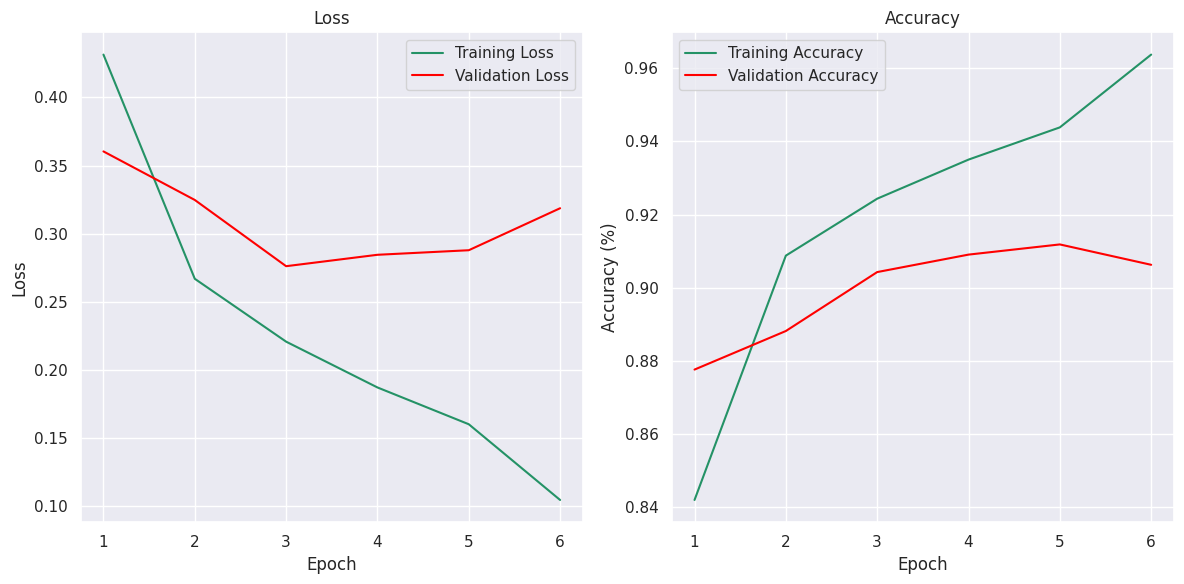

In [ ]:
CFG.epochs = 6
best_model = test_model(RNNModel, lr=3e-4)

In [ ]:
evaluate(best_model, eval_dataloader)

0.9057999849319458

Had to stop it here since there won't be any space to improve :)
However this is a result for a simple RNN, not bidirectional, max aggregation, 2 rnn layers and 2 fc layers with 0.2 dropout, tanh for rnn and relu for fc, 4e-4 lr and default weight decay

### Improving model experiment (4 points /2 each)

one change per experiment

#### Experiment 1: bidirectional RNN

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.4326
acc: 84.1


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3146
acc: 89.43
Epoch: 1/3:
	Train:                                  
		train_loss = 0.43263                                  
		train acc = 0.841%                                  
	Val:                                  
		val loss = 0.31462                                   
		val acc = 0.894%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2671
acc: 90.92


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2918
acc: 90.01
Epoch: 2/3:
	Train:                                  
		train_loss = 0.26709                                  
		train acc = 0.909%                                  
	Val:                                  
		val loss = 0.2918                                   
		val acc = 0.9%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.224
acc: 92.35


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2755
acc: 91.2
Epoch: 3/3:
	Train:                                  
		train_loss = 0.22396                                  
		train acc = 0.923%                                  
	Val:                                  
		val loss = 0.27551                                   
		val acc = 0.912%


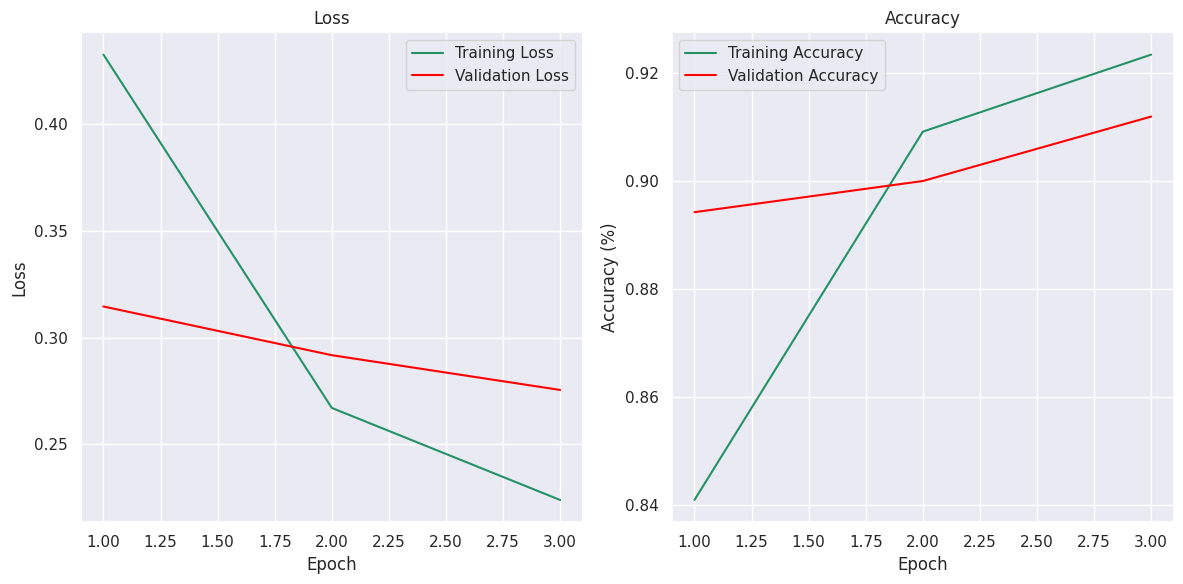

In [ ]:
CFG.epochs = 3
best_model = test_model(RNNModel)

In [ ]:
dummy_model = RNNModel(vocab_size=len(vocab), hidden_dim=512, num_classes=4).to(device)
dummy_model.load_state_dict(best_model)
evaluate(dummy_model, eval_dataloader)

0.9091999530792236

Definitelly bidirectional shows better results than not bi- one, but it takes a bit longer time and it seems that the accuracy trend goes uphill without increase in cos distance between two lines (however loss has it). Difference is minumal 1%!

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.4425
acc: 84.08


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.328
acc: 88.95
Epoch: 1/10:
	Train:                                  
		train_loss = 0.44246                                  
		train acc = 0.841%                                  
	Val:                                  
		val loss = 0.32799                                   
		val acc = 0.89%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2812
acc: 90.52


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2866
acc: 90.29
Epoch: 2/10:
	Train:                                  
		train_loss = 0.28121                                  
		train acc = 0.905%                                  
	Val:                                  
		val loss = 0.28664                                   
		val acc = 0.903%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2325
acc: 92.1


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2932
acc: 90.41
Epoch: 3/10:
	Train:                                  
		train_loss = 0.23246                                  
		train acc = 0.921%                                  
	Val:                                  
		val loss = 0.29322                                   
		val acc = 0.904%


Epoch Train: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1997
acc: 93.22


Epoch Val: 4:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3028
acc: 90.15
Epoch: 4/10:
	Train:                                  
		train_loss = 0.23246                                  
		train acc = 0.921%                                  
	Val:                                  
		val loss = 0.29322                                   
		val acc = 0.904%


Epoch Train: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1732
acc: 94.03


Epoch Val: 5:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2983
acc: 90.45
Epoch: 5/10:
	Train:                                  
		train_loss = 0.17325                                  
		train acc = 0.94%                                  
	Val:                                  
		val loss = 0.29834                                   
		val acc = 0.904%


Epoch Train: 6:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1495
acc: 94.89


Epoch Val: 6:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2933
acc: 90.82
Epoch: 6/10:
	Train:                                  
		train_loss = 0.14948                                  
		train acc = 0.949%                                  
	Val:                                  
		val loss = 0.29332                                   
		val acc = 0.908%


Epoch Train: 7:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1298
acc: 95.46


Epoch Val: 7:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3287
acc: 90.61
Epoch: 7/10:
	Train:                                  
		train_loss = 0.14948                                  
		train acc = 0.949%                                  
	Val:                                  
		val loss = 0.29332                                   
		val acc = 0.908%


Epoch Train: 8:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1141
acc: 96.01


Epoch Val: 8:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3275
acc: 90.61
Epoch: 8/10:
	Train:                                  
		train_loss = 0.14948                                  
		train acc = 0.949%                                  
	Val:                                  
		val loss = 0.29332                                   
		val acc = 0.908%


Epoch Train: 9:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.0983
acc: 96.55


Epoch Val: 9:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3778
acc: 90.47
Epoch: 9/10:
	Train:                                  
		train_loss = 0.14948                                  
		train acc = 0.949%                                  
	Val:                                  
		val loss = 0.29332                                   
		val acc = 0.908%


Epoch Train: 10:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.0875
acc: 96.91


Epoch Val: 10:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3625
acc: 90.86
Epoch: 10/10:
	Train:                                  
		train_loss = 0.08745                                  
		train acc = 0.969%                                  
	Val:                                  
		val loss = 0.36249                                   
		val acc = 0.909%


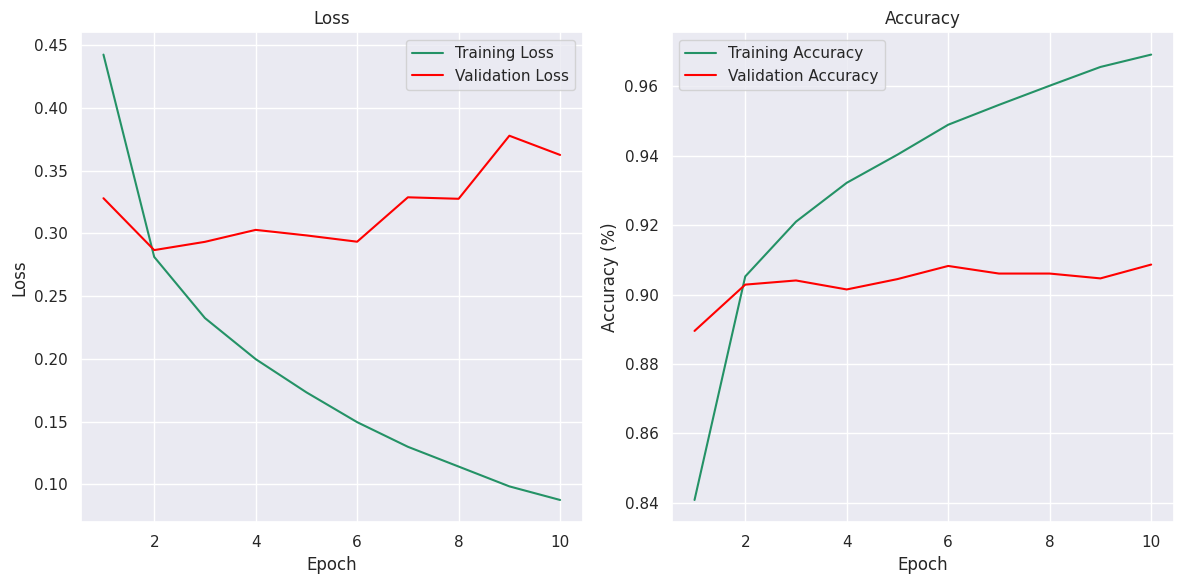

0.9081999659538269

In [ ]:
CFG.epochs = 10
model = RNNModel(vocab_size=len(vocab), hidden_dim=512, num_classes=4, bi=True, rnn_layers=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=4e-4)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX).to(device)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.5)
best_model, history = fit(model, optimizer, criterion, scheduler, train_dataloader, eval_dataloader)
plot_loss_and_acc(*history)
evaluate(best_model, eval_dataloader)

This experiment was with 3 rnn layers.
However here we see similar result but on 10 epochs and a clear overfit - loss keeps growing. To boost the quality we could use some regularization, larger dropouts, use another model etc.

#### Experiment 2: Try more complex models (LSTM)

In [ ]:
class LSTMModel(nn.Module):
  def __init__(self, vocab_size: int, hidden_dim: int = 512, num_classes: int = 4):
    super(LSTMModel, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_dim)
    self.drop = nn.Dropout(0.4)
    self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=3, batch_first=True, bidirectional=True)
    self.fc_1 = nn.Linear(in_features=hidden_dim*2, out_features=hidden_dim//2)
    self.fc_2 = nn.Linear(in_features=hidden_dim//2, out_features=num_classes)


  def forward(self, x):
    embeddings = self.embedding(x)
    x, last_cell = self.lstm(embeddings)
    x = F.tanh(x.mean(dim=1))
    x = self.fc_1(x)
    x = F.relu(x)
    x = self.drop(x)
    x = self.fc_2(x)
    return x

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.3955
acc: 86.15


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2962
acc: 90.39
Epoch: 1/3:
	Train:                                  
		train_loss = 0.39552                                  
		train acc = 0.862%                                  
	Val:                                  
		val loss = 0.29621                                   
		val acc = 0.904%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2324
acc: 92.25


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2708
acc: 91.4
Epoch: 2/3:
	Train:                                  
		train_loss = 0.23244                                  
		train acc = 0.922%                                  
	Val:                                  
		val loss = 0.2708                                   
		val acc = 0.914%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1655
acc: 94.45


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2619
acc: 91.6
Epoch: 3/3:
	Train:                                  
		train_loss = 0.16545                                  
		train acc = 0.945%                                  
	Val:                                  
		val loss = 0.26195                                   
		val acc = 0.916%


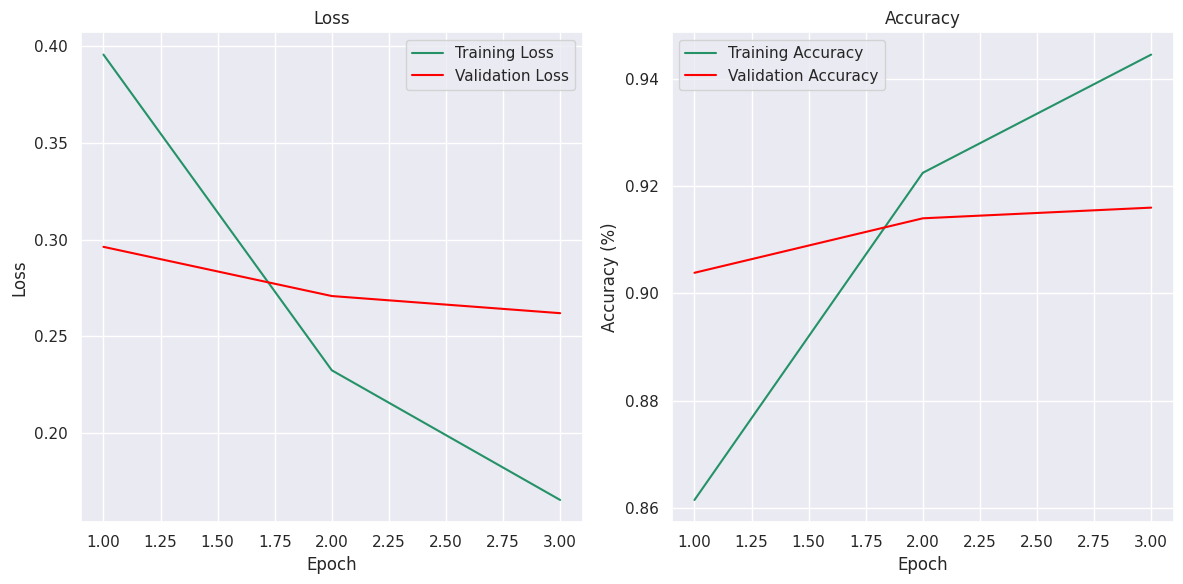

In [ ]:
CFG.epochs=3
best_model = test_model(LSTMModel, lr=3e-4)

In [ ]:
evaluate(best_model, eval_dataloader)

0.9156000018119812

Welp, the goal was to reach 91.5% accuracy. We did it with LSTM on third epoch.
Model works noticeably longer than even bi-rnn with 4 layers.
3 recurrent layers, bidirectional, 2fc. agg is mean. I'd consider it a proper choice of activation and hyperparameters.